##In this file, I will be applying my matlab fretwheel code for ipython notebook!

In [2]:
import PIL#Useful module for loading and saving images
from PIL import Image
import numpy as np#Essential library of math operations (including numpy arrays, ~ matlab matrices)
import skimage#Powerful library of operations for segmentation and transformations
import matplotlib.pyplot as plt#Essential library for plotting
import tifffile as tif# Importing this with the tifffile.c file results in faster loading (still very fast without it)

tifffile.py:246: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be very slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"


First, I'll need to load my donor, fret, and acceptor files that have a common prefix.'

In [3]:
labelEFF= raw_input('Label for written file: ')#Prefix for set of data

#Load image stacks for each channel
donorStack= tif.imread(labelEFF+'Cropbleachdonor.tif')
fretStack= tif.imread(labelEFF+'Cropbleachfret.tif')
acceptorStack= tif.imread(labelEFF+'Cropbleachacceptor.tif')

#Will make the window interactive so that we can use ginput to select points
%matplotlib qt 
plt.imshow(acceptorStack[0], vmin= 0, vmax= 1000)
plt.show()#Equivalent to 'hold on' in Matlab, allows you plot on top of current figure

Label for written file: cell7


In [4]:
#Select background area
coords= plt.ginput()

c:\Users\D\Anaconda\lib\site-packages\matplotlib\backend_bases.py:2399: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


In [5]:
#Round coordinates
x= round(coords[0][0])
y= round(coords[0][1])
print x,y

258.0 198.0


In [6]:
# #Below is an optional code to plot the position of your center/window 
# plt.plot(x,y,'o',color= 'white')
# plt.plot(x-10,y-10,'ro', color= 'red')
# plt.plot(x+10,y+10,'ro', color= 'red')
# plt.plot(x-10,y+10,'ro', color= 'red')
# plt.plot(x+10,y-10,'ro', color= 'red')

#Use first image for each channel to measure background at those coordinates
donor0= donorStack[0]
fret0= fretStack[0]
acceptor0= acceptorStack[0]


In [7]:
#Now we'll take the average background from each channel in 21x21 window
#Make sure to list submatrix as [yStart:yEnd,xStart:xEnd] cause its [rows,cols]
#Note: mean() without np. should work but it's been giving me errors
donorBack= np.mean(donor0[y-10:y+10,x-10:x+10])
fretBack= np.mean(fret0[y-10:y+10,x-10:x+10])
acceptorBack= np.mean(acceptor0[y-10:y+10,x-10:x+10])

print donorBack, fretBack, acceptorBack#Doublecheck values are reasonable


119.6575 142.795 116.5625


In [9]:
#Now we'll define bleed-through values (characteristic for your scope, collected previously)
btdonor= 0.6072;#40x air updated 1/21/15
btacceptor= 0.0437


###This is where we'll load all raw images for each timepoint, background subtract, bleed-through correct, calculate FRET efficiency, clean up image and write files to the directory.

In [10]:
import time
from tifffile import imsave

t0 = time.time()
for i in range(0,len(acceptorStack)):#Loop through stack for each channel
    donor= donorStack[i]
    fret= fretStack[i]
    acceptor= acceptorStack[i]
    
    donor= donor-donorBack#Background subtraction
    fret= fret-fretBack
    acceptor= acceptor-acceptorBack
    
    #Convert datatypes to doubles so we can get decimals from division
    donor= np.double(donor); fret= np.double(fret); acceptor= np.double(acceptor);
    fretcorrected= fret - donor*(btdonor) - acceptor*(btacceptor)#Bleedthrough correction for donor and acceptor channels.
    
    #Note: In an earlier version of the script I could just write donor[donor<0] = nan but now it says 'nan' is not defined...so:
    donor[donor<0]= float('nan')#Threshold negative values 
    fret[fret<=0]= float('nan')
    acceptor[acceptor<=0]= float('nan')
    
    #Below we calculate FRET efficiency and threshold values by using the acceptor channel image as a reference
    efficiency= 100*(fretcorrected/(fretcorrected+donor));
    acceptorMask= acceptor<200#Threshold
    maskEff= efficiency#Initialize masked matrix
    maskEff[acceptorMask]= float('nan')#At acceptorMask indices where intensity<threshold, turn to nan
    
    #This part of the code in Matlab assembled a structure with all parameters
    maskEff2= np.uint16(maskEff)#Convert data back into uint16 format to write a uint16 file
    imsave('python_writeRedo'+str(i)+'.tif',maskEff2)
    
t1= time.time()
total= t1-t0
print 'Time to calculate and write files: ', total

Time to calculate and write files:  6.14499998093


c:\Users\D\Anaconda\lib\site-packages\IPython\kernel\__main__.py:25: RuntimeWarning: invalid value encountered in less


###### Check the directory, although tifffile module couldn't write files to a stack, all the timepoints are there. The values are reasonable and match the Matlab output pretty well. In addition, this last for loop took us ~4-6 s to run whereas it took Matlab about 20s (after stripping .m file to make it comparable in tasks). One final thing that I need to check is the thresholding because the data look cleaner in matlab (fewer speckles).

###Aside from that, it looks like fretwheel.py is a faster version of fretwheel.m .

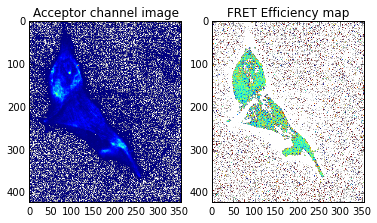

In [22]:
#Here are sample images of the last timepoint of acceptor channel image vs fret index image

%matplotlib inline

plt.subplot(1,2,1)
plt.imshow(acceptor)

plt.title('Acceptor channel image')


plt.subplot(1,2,2)
plt.imshow(maskEff, vmin= 0, vmax= 75)
plt.title('FRET Efficiency map')



In [42]:
a= donor[1][0:3]
b= fretcorrected[1][0:3]
print a,b,a/b

[    nan     nan  3.1475] [ -9.829954 -19.382654   7.106246] [        nan         nan  0.44292021]


In [27]:
a= [2,4,5,float('nan'),6,float('nan')]
b= enumerate(a)
print b

In [11]:
diego= [[1,2,3],[3,4,5],[6,7,8],[9,10,11]]
diego2= np.array(diego)
print 'This is a list of lists:',diego
print 'This is an ndarray:','\n', diego2
print 'Both work:',diego2[1,1], diego2[1][1]
print diego2[3,0]

This is a list of lists: [[1, 2, 3], [3, 4, 5], [6, 7, 8], [9, 10, 11]]
This is an ndarray: 
[[ 1  2  3]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]]
Both work: 4 4
9


In [117]:
diego3= diego2==float('nan')
print diego3
len(diego3.flatten())
test= diego3.shape
print test
test_row= str(test[0])
test_row[0:len(test_row)]

[[False False False]
 [False False False]
 [False False False]
 [False False False]]
(4L, 3L)


'4'

In [12]:
def index_array(input_array,item):
    'This function returns the indices of an element in your array'
    #Initialize lists
    indices= []
    index_rows= []
    index_cols= []
    
    #Get size of ndarray. Unfortunately it appends an 'L' to the integer. The lines below removes the last 'L' character
    dimensions= input_array.shape#Get shape of array
    row= str(dimensions[0])#For row
    row= int(row[0:len(row)])
    col= str(dimensions[0])#For column
    col= int(col[0:len(col)])
    
    #Iterates through array by rows with i and columns with j
    for i in range(0,len(input_array)):
        for j in range(0,len(input_array[0])):
            if input_array[i,j] == item:#If it finds a match, it records i and j values
                index_rows.append(i)
                index_cols.append(j)
    return index_rows, index_cols#Returns a 2 column 

      
    


In [15]:
diego3= diego2<9
new= np.array(index_array(diego3, True))
new.shape

(2L, 9L)

In [18]:
diego3[new[0],new[1]]= float('nan')

In [25]:
diego2[new]= 3
diego2

array([[ 3,  3,  3],
       [ 3,  3,  3],
       [ 3,  3,  3],
       [ 9, 10, 11]])

In [105]:
np.reshape(diego3,(3,4))

array([[ 1,  2,  3,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])